# Hackathon 1, statistics.

This project illustrates the course LEPL1109. You will study the emission of PM2.5 fine particles in Shanghai and Beijing, measured by US embassy/offices. PM2.5 refers to atmospheric particulate matter (PM) that have a diameter less than 2.5 micrometers. In other words, it's used as a measure of pollution. 


## Report content

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

•	Do not comment your results directly into cells of code. Use instead a Markdown cell. 

•	"Dry" code or results not followed by a minimum of analysis / comments will be penalized.


## Report submission

•	Deadline, see moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “Hackathons” on Moodle and the subsection “Remise Hackathon 1”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.


## Names and Noma of participants:

Part. 1: Burie Jarod | 2335-2100

Part. 2: Tejada Morillas Théo | 1349-2200

Part. 3: Sanglier Kevin | 2383-2000

Part. 4: Etlik Umit | 2930-2100

Part. 5: Clerbaux Coline | 6292-2200

Part. 6: t'Serstevens Victor | 8205-2000


# Air quality in China


PM2.5 consists of airborne particles with aerodynamic diameters less than 2.5 μm. They are known to adversely affect human
health. The U.S. Embassy in Beijing started releasing hourly PM2.5 readings in April 2008, followed by the consulates in Guangzhou, Shanghai, Chengdu, and Shenyang in November and December 2011, June 2012, and April 2013, respectively. China’s Ministry of Environmental Protection (MEP) began to report hourly PM2.5 data in 74 cities (which include the five cities with the U.S. diplomatic posts) from January 2013, which was extended to 338 cities in January 2015.

The time period for this data is between Jan 1st, 2010 to Dec 31st, 2015. Missing data are denoted as NA.

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* season: season of data in this row
* PM: PM2.5 concentration (µg/m^3)
* DEWP: Dew Point (Celsius Degree)
* TEMP: Temperature (Celsius Degree)
* HUMI: Humidity (%)
* PRES: Pressure (hPa)
* cbwd: Combined wind direction
* Iws: Cumulated wind speed (m/s)
* precipitation: hourly precipitation (mm)
* Iprec: Cumulated precipitation (mm)

Reference: 

Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220-10236.


## 1. Basic statistics


------------------------------------------------------------------------------------------------------
1.1. We will focus on PM2.5 hourly measurements done by the US offices between the 1/1/2012 and 31/12/2015 in Beijing and Shanghai. 

a) Load datasets and merge them. Take care to remove missing data (NA) and keep only days for which PM2.5 emissions are available **both** in Shanghai and Beijing (PM_US_Post). Notice that in a later question, you will also need PM2.5 emissions measured in Nongzhanguan.

Use the field 'season' to split the data of Shanghai and Bejing into:
* one sample for winter (season=4), 
* one sample for summer (season=2).
------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

In [3]:
# Load the datasets and ensure that 'NA' is considered as a missing value
beijing_pm = pd.read_csv('BeijingPM.csv', na_values=['NA'])
shanghai_pm = pd.read_csv('ShanghaiPM.csv', na_values=['NA'])

# Drop rows with missing values in the PM_US Post column for both of our datasets
beijing_pm_cleaned = beijing_pm.dropna(subset=['PM_US Post'])
shanghai_pm_cleaned = shanghai_pm.dropna(subset=['PM_US Post'])

# We merge the datasets and keep only rows where data for both Beijing AND Shanghai is available. (suffix is added to not mix data from different cities!)
merged_data = pd.merge(beijing_pm_cleaned, shanghai_pm_cleaned, on=['year', 'month', 'day', 'hour', 'season'], suffixes=('_Beijing', '_Shanghai'))

# Drop every column that is not 'year', 'month', 'day', 'hour', 'season', or the PM_US Post columns from both cities
columns_to_keep = ['year', 'month', 'day', 'hour', 'season', 'PM_US Post_Beijing', 'PM_US Post_Shanghai']

# Filter the data to keep only rows from 2012 to 2015 as the instructions say
filtered_data = merged_data[columns_to_keep]
filtered_data = filtered_data[filtered_data['year'] >= 2012]
filtered_data = filtered_data[filtered_data['year'] <= 2015]

# Just for cleanliness (we reset the indexes)
filtered_data.reset_index(drop=True, inplace=True)

# For debugging
# print(filtered_data)

# Splitting the data into winter and summer samples (4 for winter & 2 for summer)
winter_data = filtered_data[filtered_data['season'] == 4].reset_index(drop=True)
summer_data = filtered_data[filtered_data['season'] == 2].reset_index(drop=True)

# For debugging
# print(winter_data)
# print(summer_data)

b) Calculate the mean, variance, median, 25% and 75% quantiles of emissions during winter and summer in Shanghai and Beijing. Present them in clean table. Comment your results.

In [4]:
def calculate_statistics(data, city):
    return {
        'City & Season': city,
        'Mean': data.mean(),
        'Variance': data.var(),
        'Standard Deviation': data.std(), # BONUS (for our comments and interpreting our results)
        'Median/50% Quantile': data.median(),
        '25% Quantile': data.quantile(0.25),
        '75% Quantile': data.quantile(0.75),
        'Interquartile Range': data.quantile(0.75) - data.quantile(0.25), # BONUS (for out comments and interpreting our results)
        'Minimum': data.min(), # BONUS (for our comments and interpreting our results)
        'Maximum': data.max(), # BONUS (for our comments and interpreting our results)
    }


# Winter's stats for Beijing and Shanghai
winter_stats_beijing = calculate_statistics(winter_data['PM_US Post_Beijing'], 'Beijing Winter')
winter_stats_shanghai = calculate_statistics(winter_data['PM_US Post_Shanghai'], 'Shanghai Winter')

# Summer's stats for Beijing and Shanghai
summer_stats_beijing = calculate_statistics(summer_data['PM_US Post_Beijing'], 'Beijing Summer')
summer_stats_shanghai = calculate_statistics(summer_data['PM_US Post_Shanghai'], 'Shanghai Summer')

# Create a DataFrame to present our results
pd.DataFrame([winter_stats_beijing, winter_stats_shanghai, summer_stats_beijing, summer_stats_shanghai])

,City & Season,Mean,Variance,Standard Deviation,Median/50% Quantile,25% Quantile,75% Quantile,Interquartile Range,Minimum,Maximum
0,Beijing Winter,122.404926,15602.260067,124.909007,82.0,21.0,180.0,159.0,1.0,994.0
1,Shanghai Winter,76.270071,3310.005657,57.532649,60.0,36.0,99.0,63.0,8.0,651.0
2,Beijing Summer,71.840843,2978.227347,54.573138,59.0,30.0,100.0,70.0,1.0,466.0
3,Shanghai Summer,33.891807,611.481485,24.728152,29.0,16.0,46.0,30.0,1.0,224.0


From our analysis of the data, we identified three main points:

- First, the ****concentration of PM2.5 is higher in winter**, indicating higher air pollution during the colder months.

- Secondly, compared to Shanghai, the air quality in Beijing is much worse in both winter and summer. The 75% quantiles show that the most polluted days in Beijing can reach very high levels, with daily averages up to 180 µg/m3. In contrast, even on the most polluted days in Shanghai, peak pollution levels are very low, not exceeding the daily average of 99 µg/m3

- Lastly, the differences in Beijing's summer data indicate volatile (the high variance and standard deviation indicate that PM2.5 levels fluctuate significantly) and unpredictable pollution, while Shanghai, especially in summer, experiences stable and continuously low pollution (lower variance and standard deviation suggest more stable pollution levels).

Here we detail our observations and research for hypotheses :

- To obtain better insights, we added the **standard deviation (σ)** to our table. We observe that Beijing exhibits a significantly higher variance and standard deviation in PM2.5 levels compared to Shanghai. This suggests that there is greater **variability** in air quality in Beijing, with PM2.5 concentrations fluctuating more widely over time.

- We found it interesting to calculate the **interquartile range (IQR)** to make further observations and hypotheses. A larger IQR in Beijing indicates that the middle 50% of PM2.5 values are spread over a wider range, reinforcing our observations of **higher variability** in air quality. In contrast, the smaller IQR in Shanghai suggests more consistent PM2.5 levels, with **less fluctuation** in the central range of values.

- We noticed a **notable difference** between PM2.5 levels in winter and summer, with both cities showing higher mean concentrations in winter, which seemed surprising to us. We hypothesize that this could be due to increased use of coal or other fuels for heating during colder months, as well as the presence of winter inversion layers that trap pollutants near the ground. However, these are just assumptions. We found an interesting source that supports this perspective and our hypothese: [NCBI Article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4309400/).

**Overall**, our findings indicate that Beijing experiences higher and more variable PM2.5 pollution levels compared to Shanghai, with both cities facing increased pollution during the winter months.


-----------------------------------------------------------------------------------------------------------------------

1.2. Draw box plots of PM2.5 emissions in Beijing and Shanghai / summer & winter (in total 4 box plots).

Search on internet, what are the recommended maximum level of PM2.5 and comment your results.

------------------------------------------------------------------------------------------------------------------------



In Beijing Winter, PM2.5 levels significantly exceed the WHO threshold with a median value far above the safe limit.
This box plot reveals a high number of outliers, especially in winter, suggesting frequent extreme pollution events.

In Shanghai Winter, PM2.5 levels also exceed the WHO threshold, though the median is lower than Beijing.
Outliers are present but less frequent (suggesting more controlled pollution levels compared to Beijing).

In Beijing Summer, pollution levels are lower than in winter but still exceed the WHO limit (maybe indicating pollution issues).
The box plot shows moderate outliers and a high median, indicating frequent pollution spikes.

In Shanghai Summer, PM2.5 levels are the lowest of all, with a median closest to the WHO threshold, though still above it.
The data distribution is tighter, suggesting more stable air quality with fewer extreme pollution events.



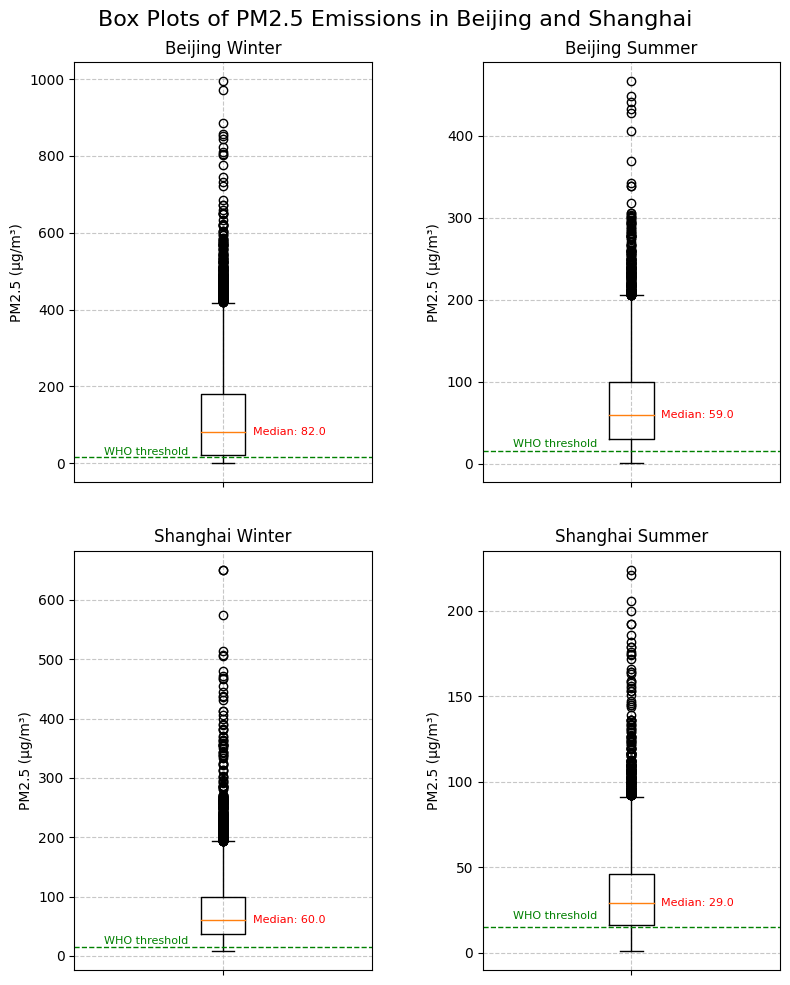

In [5]:
# WHO recommended maximum PM2.5 level (24-hour mean)
# We add a horizontal line representing the maximum PM2.5 concentration recommended 
# by the WHO (15 µg/m³) at each plot, just for reference and observations. 
who_limit = 15

# Create subplots for 4 box plots
fig, axes = plt.subplots(2, 2, figsize=(8, 10))

# Boxplot for Beijing Winter
axes[0][0].boxplot(winter_data['PM_US Post_Beijing'])
axes[0][0].set_title('Beijing Winter')
# Add a horizontal line representing the WHO recommended maximum PM2.5 level
axes[0][0].axhline(who_limit, color='green', linestyle='--', linewidth=1)
axes[0][0].text(0.6, 20, 'WHO threshold', color='green', fontsize=8)
# Add the median value to the plot
median_beijing_winter = winter_data['PM_US Post_Beijing'].median()
axes[0][0].text(1.10, median_beijing_winter, f'Median: {median_beijing_winter:.1f}', 
                va='center', ha='left', fontsize=8, color='red')

print("In Beijing Winter, PM2.5 levels significantly exceed the WHO threshold with a median value far above the safe limit.")
print("This box plot reveals a high number of outliers, especially in winter, suggesting frequent extreme pollution events.\n")

# Boxplot for Shanghai Winter
axes[1][0].boxplot(winter_data['PM_US Post_Shanghai'])
axes[1][0].set_title('Shanghai Winter')
axes[1][0].axhline(who_limit, color='green', linestyle='--', linewidth=1)
axes[1][0].text(0.6, 20, 'WHO threshold', color='green', fontsize=8)
median_shangai_winter = winter_data['PM_US Post_Shanghai'].median()
axes[1][0].text(1.10, median_shangai_winter, f'Median: {median_shangai_winter:.1f}', 
                va='center', ha='left', fontsize=8, color='red')

print("In Shanghai Winter, PM2.5 levels also exceed the WHO threshold, though the median is lower than Beijing.")
print("Outliers are present but less frequent (suggesting more controlled pollution levels compared to Beijing).\n")

# Boxplot for Beijing Summer
axes[0][1].boxplot(summer_data['PM_US Post_Beijing'])
axes[0][1].set_title('Beijing Summer')
axes[0][1].axhline(who_limit, color='green', linestyle='--', linewidth=1)
axes[0][1].text(0.6, 20, 'WHO threshold', color='green', fontsize=8)
median_beijing_summer = summer_data['PM_US Post_Beijing'].median()
axes[0][1].text(1.10, median_beijing_summer, f'Median: {median_beijing_summer:.1f}', 
                va='center', ha='left', fontsize=8, color='red')

print("In Beijing Summer, pollution levels are lower than in winter but still exceed the WHO limit (maybe indicating pollution issues).")
print("The box plot shows moderate outliers and a high median, indicating frequent pollution spikes.\n")

# Boxplot for Shanghai Summer
axes[1][1].boxplot(summer_data['PM_US Post_Shanghai'])
axes[1][1].set_title('Shanghai Summer')
axes[1][1].axhline(who_limit, color='green', linestyle='--', linewidth=1)
axes[1][1].text(0.6, 20, 'WHO threshold', color='green', fontsize=8)
median_shangai_summer = summer_data['PM_US Post_Shanghai'].median()
axes[1][1].text(1.10, median_shangai_summer, f'Median: {median_shangai_summer:.1f}', 
                va='center', ha='left', fontsize=8, color='red')

print("In Shanghai Summer, PM2.5 levels are the lowest of all, with a median closest to the WHO threshold, though still above it.")
print("The data distribution is tighter, suggesting more stable air quality with fewer extreme pollution events.\n")
             
# Add titles and labels to our plots
fig.suptitle('Box Plots of PM2.5 Emissions in Beijing and Shanghai', fontsize=16)
for axes in axes.flat:
    axes.grid(True, linestyle='--', alpha=0.7)
    axes.set_ylabel('PM2.5 (µg/m³)')
    axes.set_xticklabels([''])

plt.tight_layout(h_pad=3, w_pad=4)
plt.show()

#### **WHO Guidelines for PM2.5** <a id='boxplots_ref'></a>
<img src="PM2.5.png" alt="World Health Organization guidelines" width="1000" />

According to the World Health Organization (WHO), the recommended maximum level of PM2.5 is:
- **15 µg/m³** for the 24-hour mean
- **5 µg/m³** for the annual mean

As we can see in the analysis, the actual PM2.5 levels in both Beijing and Shanghai consistently exceed these recommended limits! Even in summer, where levels are lower, both cities still **surpass** the 24-hour mean limit of **15 µg/m³**. Beijing in winter with a mean of over 120 µg/m³ is the **worst** as it significantly exceeds the safe limits.

#### **Observations based on our Boxplots**

**Here’s what we think about the box plots, our observations and hypotheses are as follows:**

The box plots of PM2.5 emissions show that both Beijing and Shanghai consistently **exceed** the *WHO's recommended 24-hour mean limit* of **15 µg/m³** throughout the year. We noticed that Beijing has higher medians and a greater number of outliers, particularly during the winter months, which points to more severe and variable pollution levels. The asymmetry distributions in the box plots could mean that extreme pollution events are fairly common. Based on these observations, we hypothesize that there is a strong case for implementing effective pollution control measures, and we believe that the gamma distribution would be suitable for further statistical modeling of PM2.5 concentrations.


## 2. Fit of distributions 


------------------------------------------------------------------------------------------------------

2.1. Fit a Gamma distribution to PM2.5 emissions in Beijing and Shanghai (winter & summer). Warning, in python, the Gamma distribution has a parameter of location which translate the distribution from $[0,+\infty)$ to $[loc,+\infty)$. Force its value to zero during the calibration (option floc=0) to consider only positive values.

a) Estimate Gamma parameters by log-likelihood maximization (MLE). Present them in a clean table **AND** calculate the log-likelihood.  

------------------------------------------------------------------------------------------------------

In [6]:
# Fit Gamma distribution to winter and summer data
# (notes: floc=0 is used to fix the location parameter at 0)
gamma_params_winter_beijing = st.gamma.fit(winter_data['PM_US Post_Beijing'], floc=0)
shape_winter_beijing, loc_winter_beijing, scale_winter_beijing = gamma_params_winter_beijing

gamma_params_winter_shanghai = st.gamma.fit(winter_data['PM_US Post_Shanghai'], floc=0)
shape_winter_shanghai, loc_winter_shanghai, scale_winter_shanghai = gamma_params_winter_shanghai

gamma_params_summer_beijing = st.gamma.fit(summer_data['PM_US Post_Beijing'], floc=0)
shape_summer_beijing, loc_summer_beijing, scale_summer_beijing = gamma_params_summer_beijing

gamma_params_summer_shanghai = st.gamma.fit(summer_data['PM_US Post_Shanghai'], floc=0)
shape_summer_shanghai, loc_summer_shanghai, scale_summer_shanghai = gamma_params_summer_shanghai

# Print the estimated parameters
print("Gamma parameters for Beijing Winter:", gamma_params_winter_beijing)
print("Gamma parameters for Shanghai Winter:", gamma_params_winter_shanghai)
print("Gamma parameters for Beijing Summer:", gamma_params_summer_beijing)
print("Gamma parameters for Shanghai Summer:", gamma_params_summer_shanghai)

# Calculate the log-likelihood for each fitted distribution
log_likelihood_winter_beijing = st.gamma.logpdf(winter_data['PM_US Post_Beijing'], shape_winter_beijing, loc_winter_beijing, scale_winter_beijing).sum()
log_likelihood_winter_shanghai = st.gamma.logpdf(winter_data['PM_US Post_Shanghai'], shape_winter_shanghai, loc_winter_shanghai, scale_winter_shanghai).sum()
log_likelihood_summer_beijing = st.gamma.logpdf(summer_data['PM_US Post_Beijing'], shape_summer_beijing, loc_summer_beijing, scale_summer_beijing).sum()
log_likelihood_summer_shanghai = st.gamma.logpdf(summer_data['PM_US Post_Shanghai'], shape_summer_shanghai, loc_summer_shanghai, scale_summer_shanghai).sum()

# Create a DataFrame to present the estimated parameters in a clean table
print('\n Here we present the estimated parameters and the Log-Likelihood for the Gamma distribution in a clean table with a DataFrame:')
pd.DataFrame({
    'City & Season': ['Beijing Winter', 'Shanghai Winter', 'Beijing Summer', 'Shanghai Summer'],
    'Shape': [shape_winter_beijing, shape_winter_shanghai, shape_summer_beijing, shape_summer_shanghai],
    'Scale': [scale_winter_beijing, scale_winter_shanghai, scale_summer_beijing, scale_summer_shanghai],
    'Log-Likelihood': [log_likelihood_winter_beijing, log_likelihood_winter_shanghai, log_likelihood_summer_beijing, log_likelihood_summer_shanghai]
})

Gamma parameters for Beijing Winter: (0.9398667638483656, 0, 130.23646591176578)
Gamma parameters for Shanghai Winter: (2.2501536393635315, 0, 33.89549491020711)
Gamma parameters for Beijing Summer: (1.7007982101972299, 0, 42.239486696756984)
Gamma parameters for Shanghai Summer: (1.7587442556660318, 0, 19.270457953013143)

 Here we present the estimated parameters and the Log-Likelihood for the Gamma distribution in a clean table with a DataFrame:


,City & Season,Shape,Scale,Log-Likelihood
0,Beijing Winter,0.939867,130.236466,-48091.586067
1,Shanghai Winter,2.250154,33.895495,-42926.791179
2,Beijing Summer,1.700798,42.239487,-43175.928971
3,Shanghai Summer,1.758744,19.270458,-36870.989338


b) Plot the 4 histograms of PM2.5 and add the fitted gamma pdf’s on the same plot. What is your overall feeling about the quality of estimation?

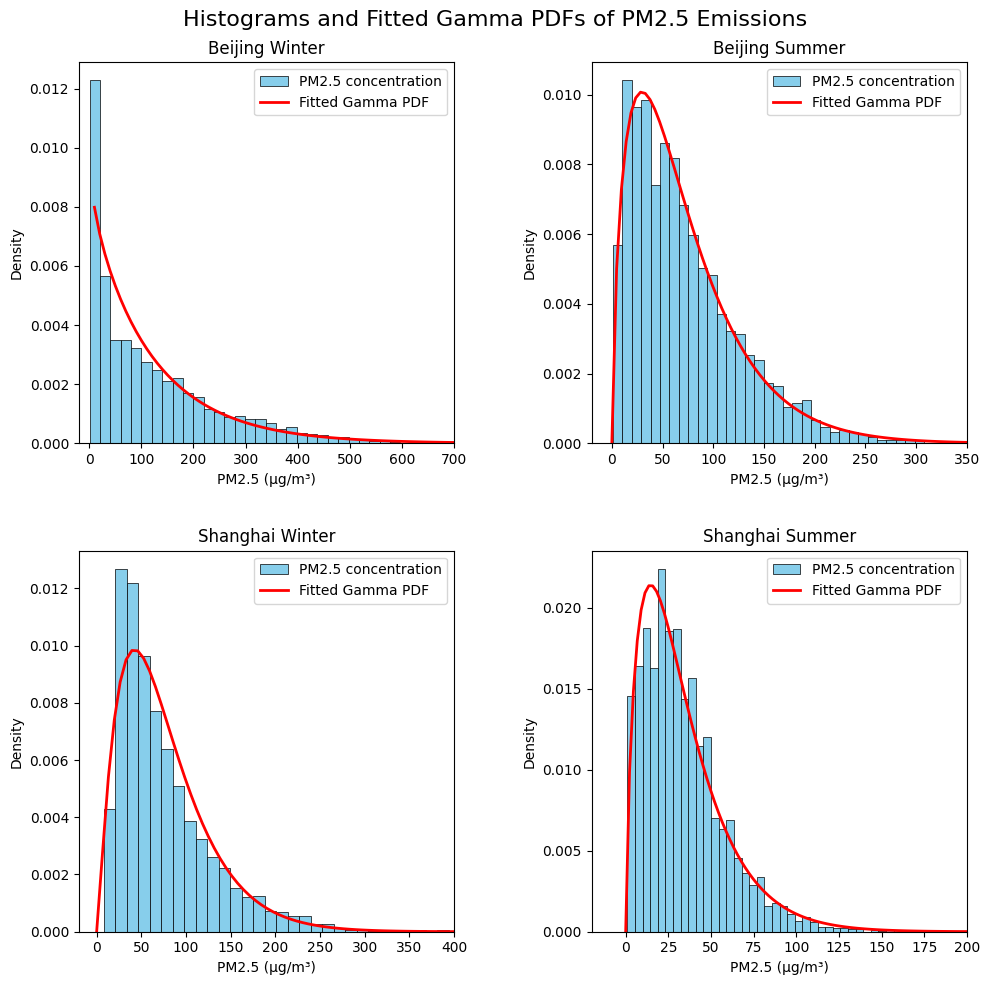

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Linear space for the x-axis and fitted PDFs
x_winter_beijing = np.linspace(0, winter_data['PM_US Post_Beijing'].max(), 100)
x_winter_shanghai = np.linspace(0, winter_data['PM_US Post_Shanghai'].max(), 100)
x_summer_beijing = np.linspace(0, summer_data['PM_US Post_Beijing'].max(), 100)
x_summer_shanghai = np.linspace(0, summer_data['PM_US Post_Shanghai'].max(), 100)

# We use the fitted parameters to calculate the PDFs
pdf_gamma_winter_beijing = st.gamma.pdf(x_winter_beijing, shape_winter_beijing, loc_winter_beijing, scale_winter_beijing)
pdf_gamma_winter_shanghai = st.gamma.pdf(x_winter_shanghai, shape_winter_shanghai, loc_winter_shanghai, scale_winter_shanghai)
pdf_gamma_summer_beijing = st.gamma.pdf(x_summer_beijing, shape_summer_beijing, loc_summer_beijing, scale_summer_beijing)
pdf_gamma_summer_shanghai = st.gamma.pdf(x_summer_shanghai, shape_summer_shanghai, loc_summer_shanghai, scale_summer_shanghai)

# Histogram for Beijing Winter
axes[0][0].hist(winter_data['PM_US Post_Beijing'], color="skyblue", bins=50, density=True, label='PM2.5 concentration', edgecolor='black', linewidth=0.5)
axes[0][0].plot(x_winter_beijing, pdf_gamma_winter_beijing, color='r', lw=2, label='Fitted Gamma PDF')
axes[0][0].set_title('Beijing Winter')
axes[0][0].set_xlim(-20, 700)

# Histogram for Shanghai Winter
axes[1][0].hist(winter_data['PM_US Post_Shanghai'], color="skyblue", bins=50, density=True, label='PM2.5 concentration', edgecolor='black', linewidth=0.5)
axes[1][0].plot(x_winter_shanghai, pdf_gamma_winter_shanghai, color='r', lw=2, label='Fitted Gamma PDF')
axes[1][0].set_title('Shanghai Winter')
axes[1][0].set_xlim(-20, 400)

# Histogram for Beijing Summer
axes[0][1].hist(summer_data['PM_US Post_Beijing'], color="skyblue", bins=50, density=True, label='PM2.5 concentration', edgecolor='black', linewidth=0.5)
axes[0][1].plot(x_summer_beijing, pdf_gamma_summer_beijing, color='r', lw=2, label='Fitted Gamma PDF')
axes[0][1].set_title('Beijing Summer')
axes[0][1].set_xlim(-20, 350)

# Histogram for Shanghai Summer
axes[1][1].hist(summer_data['PM_US Post_Shanghai'], color="skyblue", bins=50, density=True, label='PM2.5 concentration', edgecolor='black', linewidth=0.5)
axes[1][1].plot(x_summer_shanghai, pdf_gamma_summer_shanghai, color='r', lw=2, label='Fitted Gamma PDF')
axes[1][1].set_title('Shanghai Summer')
axes[1][1].set_xlim(-20, 200)

# Add titles and labels to our plots
fig.suptitle('Histograms and Fitted Gamma PDFs of PM2.5 Emissions', fontsize=16)
for axes in axes.flat:
    axes.legend()
    axes.set_xlabel('PM2.5 (µg/m³)')
    axes.set_ylabel('Density')

plt.tight_layout(h_pad=3, w_pad=4)
plt.show()

We believe **the overall quality of the estimation is quite good** based on the visual fit of the gamma distribution (the red curve) to our PM2.5 data (represented by the histograms). In most cases, particularly in the **summer data**, the fitted gamma curve **closely follows** the shape of the histogram, suggesting a **strong alignment** between the model and the observed data.

**However,** we notice a few points where the fit is less perfect, especially in the **winter data**. The presence of **outliers** in the winter datasets (as seen in [our boxplots](#boxplots_ref)) for both Beijing and Shanghai may explain the slight deviations at the tails of the distributions. These outliers make it harder for the gamma distribution to capture the full spread of the data, leading to some underfitting at the extremes.

**Overall**, the model captures the general trend of the PM2.5 concentrations, with the log-likelihood values reinforcing that our parameters are a good fit. We could further refine the analysis by comparing the likelihoods between different seasons and cities, to quantify the strength of the fit.

So, in summary, the gamma distribution is **well-fitted** for most of the data, but the winter distributions present challenges due to data sparsity and outliers.

------------------------------------------------------------------------------------------------------

2.2. You have fitted 4 gamma random variables to PM2.5 emissions in Shanghai, Beijing during summer and winter.

* Present the anatytical formulas of the mean and standard deviation of a gamma distribution. Calculate the expected levels and the standard devations of the PM2.5 emissions (in Shanghai, Beijing during summer and winter) relying on the fitted gamma random variables. 
* Calculate the 25%, 50% and 75% percentiles of these gamma distributions.
* Compare your results with the empirical statistics previously computed. Please comment your results.

------------------------------------------------------------------------------------------------------

Here we present the analytical formulas for the mean, variance and standard deviation of a gamma distribution (helpful for the next thing of the question):

- **Mean**: 
  \[
  $\mu = \alpha \cdot \beta$
  \]

- **Variance**: 
  \[
  $\sigma^2 = \alpha \cdot \beta^2$
  \]

- **Standard Deviation**:
  \[
  $\sigma = \sqrt{\alpha} \cdot \beta$
  \]

In [8]:
# Ours analytical formulas converted in Python code:
    # Mean = shape * scale
    # Variance = shape * scale ** 2
    # Standard Deviation = sqrt(shape) * scale
    # where shape is α and scale is β

# Calculate the expected levels (mean), standard deviations and percentiles (25%, 50%, 75%) of our Gamma distributions
means_gamma = {
    'Beijing Winter': shape_winter_beijing * scale_winter_beijing,
    'Shanghai Winter': shape_winter_shanghai * scale_winter_shanghai,
    'Beijing Summer': shape_summer_beijing * scale_summer_beijing,
    'Shanghai Summer': shape_summer_shanghai * scale_summer_shanghai
}
standard_deviations_gamma = {
    'Beijing Winter': np.sqrt(shape_winter_beijing) * scale_winter_beijing,
    'Shanghai Winter': np.sqrt(shape_winter_shanghai) * scale_winter_shanghai,
    'Beijing Summer': np.sqrt(shape_summer_beijing) * scale_summer_beijing,
    'Shanghai Summer': np.sqrt(shape_summer_shanghai) * scale_summer_shanghai
}
percentiles_gamma = {
    'Beijing Winter': st.gamma.ppf([0.25, 0.5, 0.75], shape_winter_beijing, loc_winter_beijing, scale_winter_beijing),
    'Shanghai Winter': st.gamma.ppf([0.25, 0.5, 0.75], shape_winter_shanghai, loc_winter_shanghai, scale_winter_shanghai),
    'Beijing Summer': st.gamma.ppf([0.25, 0.5, 0.75], shape_summer_beijing, loc_summer_beijing, scale_summer_beijing),
    'Shanghai Summer': st.gamma.ppf([0.25, 0.5, 0.75], shape_summer_shanghai, loc_summer_shanghai, scale_summer_shanghai)
}

# Bonus for our comments
variances_gamma = {
    'Beijing Winter': shape_winter_beijing * scale_winter_beijing ** 2,
    'Shanghai Winter': shape_winter_shanghai * scale_winter_shanghai ** 2,
    'Beijing Summer': shape_summer_beijing * scale_summer_beijing ** 2,
    'Shanghai Summer': shape_summer_shanghai * scale_summer_shanghai ** 2
}

# Create a DataFrame to present the results
print('Here we present a clean table to compare the statistics of our fitted Gamma distributions with the empirical statistics (data):')
pd.DataFrame({
    'City & Season': ['Beijing Winter', 'Shanghai Winter', 'Beijing Summer', 'Shanghai Summer'],
    'Mean (Gamma)': list(means_gamma.values()),
    'Mean (Data)': [winter_stats_beijing['Mean'], winter_stats_shanghai['Mean'], summer_stats_beijing['Mean'], summer_stats_shanghai['Mean']],
    'Variance (Gamma) (Bonus)': list(variances_gamma.values()),
    'Variance (Data) (Bonus)': [winter_stats_beijing['Variance'], winter_stats_shanghai['Variance'], summer_stats_beijing['Variance'], summer_stats_shanghai['Variance']],
    'Standard Deviation (Gamma)': list(standard_deviations_gamma.values()),
    'Standard Deviation (Data)': [winter_stats_beijing['Standard Deviation'], winter_stats_shanghai['Standard Deviation'], summer_stats_beijing['Standard Deviation'], summer_stats_shanghai['Standard Deviation']],
    '25% Percentile (Gamma)': [percentiles_gamma['Beijing Winter'][0], percentiles_gamma['Shanghai Winter'][0], percentiles_gamma['Beijing Summer'][0], percentiles_gamma['Shanghai Summer'][0]],
    '25% Percentile (Data)': [winter_stats_beijing['25% Quantile'], winter_stats_shanghai['25% Quantile'], summer_stats_beijing['25% Quantile'], summer_stats_shanghai['25% Quantile']],
    '50% Percentile/Median (Gamma)': [percentiles_gamma['Beijing Winter'][1], percentiles_gamma['Shanghai Winter'][1], percentiles_gamma['Beijing Summer'][1], percentiles_gamma['Shanghai Summer'][1]],
    '50% Percentile/Median (Data)': [winter_stats_beijing['Median/50% Quantile'], winter_stats_shanghai['Median/50% Quantile'], summer_stats_beijing['Median/50% Quantile'], summer_stats_shanghai['Median/50% Quantile']],
    '75% Percentile (Gamma)': [percentiles_gamma['Beijing Winter'][2], percentiles_gamma['Shanghai Winter'][2], percentiles_gamma['Beijing Summer'][2], percentiles_gamma['Shanghai Summer'][2]],
    '75% Percentile (Data)': [winter_stats_beijing['75% Quantile'], winter_stats_shanghai['75% Quantile'], summer_stats_beijing['75% Quantile'], summer_stats_shanghai['75% Quantile']]
})

Here we present a clean table to compare the statistics of our fitted Gamma distributions with the empirical statistics (data):


,City & Season,Mean (Gamma),Mean (Data),Variance (Gamma) (Bonus),Variance (Data) (Bonus),Standard Deviation (Gamma),Standard Deviation (Data),25% Percentile (Gamma),25% Percentile (Data),50% Percentile/Median (Gamma),50% Percentile/Median (Data),75% Percentile (Gamma),75% Percentile (Data)
0,Beijing Winter,122.404926,122.404926,15941.584940,15602.260067,126.259989,124.909007,32.991858,21.0,82.709766,82.0,169.698824,180.0
1,Shanghai Winter,76.270071,76.270071,2585.211811,3310.005657,50.844978,57.532649,38.889197,36.0,65.317626,60.0,101.848569,99.0
2,Beijing Summer,71.840843,71.840843,3034.520348,2978.227347,55.086481,54.573138,31.494866,30.0,58.356072,59.0,97.712423,100.0
3,Shanghai Summer,33.891807,33.891807,653.110646,611.481485,25.556030,24.728152,15.160290,16.0,27.729424,29.0,46.005220,46.0


Upon comparing the results with the previously computed empirical statistics, it becomes clear that our fitted Gamma distributions yield **identical means** to those of the empirical datasets. This is expected. In terms of **variance**, however, we observe that the theoretical variances are similar to, but not exactly identical with the empirical variances. But when we switch to **standard deviations**, we see an even closer alignment between the theoretical and empirical values. This similarity in standard deviations is actually **more precise** and therefore **more informative** for our analysis. Since the standard deviation directly reflects the variability in the data, this stronger match suggests that the Gamma distribution provides a reliable fit for capturing the **spread** of values in our datasets. When we compare the **percentiles**, we see more variation. The differences are more noticeable at the **25th and 75th percentiles**, particularly in the **Beijing Winter** dataset. This discrepancy can be explained by two main factors: the presence of **outliers**, which tend to affect the distribution’s tails more than the central values, and the fact that the Gamma distribution may not capture all aspects of the empirical distribution’s **skewness**.

Across different seasons and cities, we find that the discrepancies between theoretical and empirical percentiles are generally more pronounced in datasets with **higher variability**, such as Beijing Winter, and less noticeable in datasets with **lower variability**, like Shanghai Summer.

In **conclusion**, the fitted Gamma distributions provide a good approximation of the central tendencies (**mean** and **median**) and variability (**standard deviation**) in the empirical data. However, the slight differences in variances and percentiles highlight the Gamma distribution's limitations in modeling the data's **tails**, especially in datasets with outliers. This observation is consistent with our previous findings in section 2.1b, where we noted that the Gamma distribution fit was less accurate for the winter data due to these **outliers**.


------------------------------------------------------------------------------------------------------

2.3. The quality of the MLE estimators depends upon many factors. One way to estimate it is to bootstrap the dataset. We will focus here exclusively on PM2.5 emissions in Beijing, during the winter time.

* Bootstrap 1000 times a sample of 6000 daily emissions for Beijing (winter) and plot an histogram of estimated alpha and scale parameters.

* Compute a 5% confidence interval for parameter(s) estimates for the best distribution obtained by MLE. 

* How do you interpret the results? Is the accuracy good?

------------------------------------------------------------------------------------------------------

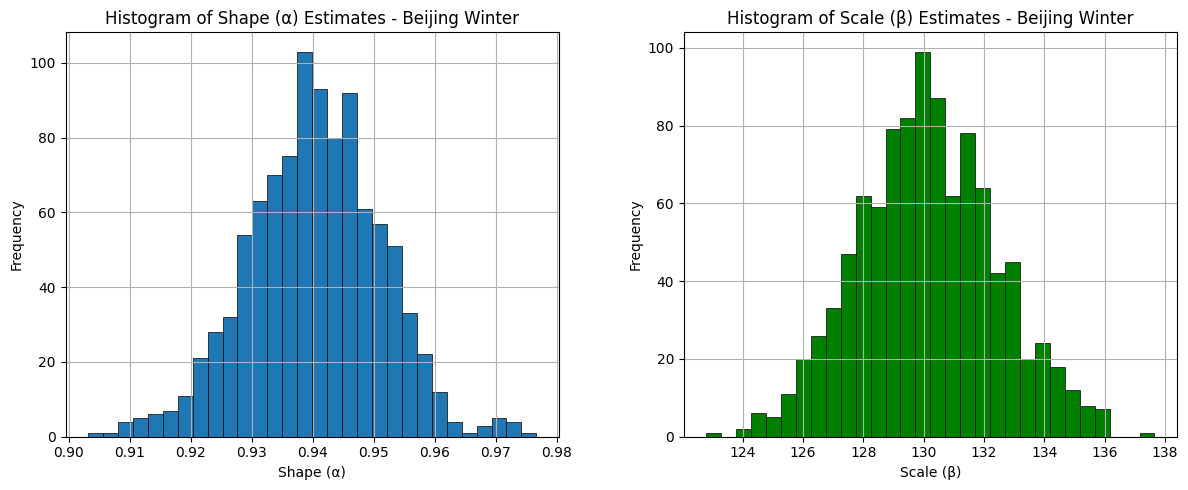

Alpha confidence interval: [0.91853396 0.96047065]
Scale confidence interval: [125.78547359 134.78749179]


,Parameter,2.5%,97.5%
,Shape (α),0.918534,0.960471
,Scale (β),125.785474,134.787492


In [9]:
shape_est = []
scale_est = []
nb_bootstrap = 1000
nb_samples = 6000

for _ in range(nb_bootstrap):
    sample = winter_data['PM_US Post_Beijing'].sample(n=nb_samples, replace=True)
    shape, loc, scale = st.gamma.fit(sample, floc=0)
    shape_est.append(shape)
    scale_est.append(scale)

shape_est = np.array(shape_est)
scale_est = np.array(scale_est)

# Plot our histograms of our estimated parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(shape_est, bins=30, edgecolor='black', linewidth=0.5)
axes[0].set_title('Histogram of Shape (α) Estimates - Beijing Winter')
axes[0].set_xlabel('Shape (α)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

axes[1].hist(scale_est, bins=30, color='g', edgecolor='black', linewidth=0.5)
axes[1].set_title('Histogram of Scale (β) Estimates - Beijing Winter')
axes[1].set_xlabel('Scale (β)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout(w_pad=4)
plt.show()

# Compute 5% confidence intervals for the alpha and scale estimates
shape_conf_interval = np.percentile(shape_est, [2.5, 97.5])
scale_conf_interval = np.percentile(scale_est, [2.5, 97.5])

print("Alpha confidence interval:", shape_conf_interval)
print("Scale confidence interval:", scale_conf_interval)

conf_int_table = pd.DataFrame({
    'Parameter': ['Shape (α)', 'Scale (β)'],
    '2.5%': [shape_conf_interval[0], scale_conf_interval[0]],
    '97.5%': [shape_conf_interval[1], scale_conf_interval[1]]
})

conf_int_table.index = ['', '']

display(conf_int_table)

From the histograms of the **shape (α)** and **scale (β)** estimates for PM2.5 emissions in Beijing during winter, we can see that our MLE estimators are performing well. Both the shape (α) and scale (β) estimates are centered around their means with a symmetric (like a bell) distribution, suggesting that our bootstrap sampling is producing consistent estimates with limited skewness or extreme outliers. 

The **5% confidence intervals**, calculated from the 2.5th and 97.5th percentiles of the bootstrap samples, provide a robust range for both parameters, giving us 95% confidence that the true values lie within these intervals. The interval for the **shape (α)** parameter is relatively tight, indicating low variability and a more stable estimate, while the **scale (β)** interval is slightly wider, hinting at some sensitivity to sample variation. 

**Overall**, we interpret this as a good level of accuracy for our MLE estimators, as the central tendencies are well captured, making these estimates reliable for representing the Gamma distribution of PM2.5 emissions in Beijing’s winter. **However**, we also recognize that if we were to focus on capturing extreme pollution events or the distribution tails more accurately, additional methods or further bootstrapping could help account for rare events. These results, support the use of our MLE estimates for further analysis of pollution levels while keeping in mind the limitations for extreme values!



## 3. Regression and forecasting 

------------------------------------------------------------------------------------------------------

3.1. In this question, you will determine if PM2.5 emissions levels depends upon weather conditions. We focus
on emissions measured by the US embassy in Beijing, during winter.

Regress PM2.5 emissions in Beijing (season 4) with respect to:
 * DEWP: Dew Point (Celsius Degree)
 * TEMP: Temperature (Celsius Degree)
 * HUMI: Humidity (%)
 * PRES: Pressure (hPa)
 * cbwd: Combined wind direction
 * Iws: Cumulated wind speed (m/s)
 * precipitation: hourly precipitation (mm)

The variable 'cbwd' is categorical. Convert it into dummy variables (0 or 1) with panda.get_dummies. Do not forget to drop one modality of this variable. Remove lines from the dataset with NaN entries.

* Use the OLS() function of the package statsmodels.api to perform the linear regression. 
* Comment your results (goodness of fit, R2, F-stat and T-stats of coefficients)
* Answer this : Does high hourly precipitation (mm) mitigate PM2.5 emissions?

------------------------------------------------------------------------------------------------------

In [10]:
##########################################
#       Prepare the dataset
##########################################

# Load a new dataset with 'NA' as missing values (As recommended by TAs)
beijing_pm_reg = pd.read_csv('BeijingPM.csv', na_values=['NA'])
winter_data_beijing = beijing_pm_reg[beijing_pm['season'] == 4]

# We select our explanatory variables
variables = ['PM_US Post', 'DEWP', 'TEMP', 'HUMI', 'PRES', 'cbwd', 'Iws', 'precipitation']

winter_data_beijing = winter_data_beijing[variables].dropna()

# Convert 'cbwd' into dummy variables and dropping one category/modality to avoid multicollinearity!!
cbwd_dummies = pd.get_dummies(winter_data_beijing['cbwd'], drop_first=True)
cbwd_dummies = cbwd_dummies.astype(float)

##########################################
#   Perform the OLS linear regression
##########################################

# Our dependent variable
Y = winter_data_beijing['PM_US Post']
# Our independent variables, with the 'cbwd' dummy variables
X = winter_data_beijing[['DEWP', 'TEMP', 'HUMI', 'PRES', 'Iws', 'precipitation']]
X = pd.concat([X, cbwd_dummies], axis=1)

# Add a constant term to the independent variables
Xm = sm.add_constant(X)

# Create the OLS model
model = sm.OLS(Y, Xm)
# Fit the model
results = model.fit()

# Print the summary of the regression results
print("We conducted an OLS regression to investigate whether PM2.5 emission levels in Beijing during winter depend on various weather conditions.\nOur regression model included 7 independent variables\n")
print(results.summary())

We conducted an OLS regression to investigate whether PM2.5 emission levels in Beijing during winter depend on various weather conditions.
Our regression model included 7 independent variables

                            OLS Regression Results                            
Dep. Variable:             PM_US Post   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1245.
Date:                Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:26:24   Log-Likelihood:                -73083.
No. Observations:               12418   AIC:                         1.462e+05
Df Residuals:                   12408   BIC:                         1.463e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                

#### **Goodness of Fit**
To assess the quality of our regression, we will rely on theory of our course, specifically the concept of $ R^2 $.

$ R^2 $ represents the decomposition of errors, indicating the proportion of variance explained by the model, ranging between 0 and 1. If $ R^2 $  is close to 1, we have a good model. The closer $ R^2 $  is to 1, the greater the explained variability, meaning the points lie very close to the regression line. Conversely, if $ R^2 $  is near 0, the points are more scattered. Its formula is as follows:

$$
R^2 = \frac{\text{SSR}}{\text{SST}}
$$

where $SSR$ is the variability that our linear regression model can reproduce, and $SST$ is the total distance between the observed and predicted values.

The adjusted $ R^2 $, seen in our regression output, considers the number of explanatory variables in the model. It adjusts based on the number of predictors included, so we expect it to be close to $ R^2 $. This measure is more informative, as it corrects for the variability concept by accounting for the number of predictors.

- **$ R^2 $:** Our model achieved an $ R^2 $ value of **0.474**, meaning that about **47.4%** of the variability in PM2.5 emissions is explained by these weather factors. While this doesn’t cover all variations, it indicates a reasonable model fit and suggests that the included weather conditions have a significant effect on pollution levels.

- **Adjusted R²:** The adjusted R-squared also equals **0.474**, which shows that every variable contributes meaningfully without overfitting.

#### **F-Stat**

- **F-stat:** The F-stat is quite high at **1245**, with a p-value close to zero, indicating that the overall model is statistically significant. This means the combination of weather conditions provides a better understanding of PM2.5 levels than if we had no predictors at all.

#### **Key Coefficients and t-stats**

| Variable          | Coefficient  | t-statistic | P-value   | Our interpretation (assumptions) |
|-------------------|--------------|-------------|-----------|----------------|
| **DEWP**          | 0.70         | 1.637       | 0.102     | Positive but not statistically significant at the 5% level. |
| **TEMP**          | 3.15         | 8.284       | <0.001    | Higher temperatures increase PM2.5 levels. |
| **HUMI**          | 2.81         | 23.162      | <0.001    | Higher humidity raises PM2.5 levels significantly. |
| **PRES**          | -2.38        | -17.025     | <0.001    | Higher pressure reduces PM2.5 levels. |
| **Iws**           | -0.09        | -6.448      | <0.001    | Increased wind speed lowers PM2.5. |
| **Precipitation** | -226.08      | -15.270     | <0.001    | More precipitation leads to a notable reduction in PM2.5 levels. |
| **NW (cbwd)**     | -8.03        | -3.204      | 0.001     | Winds from NW reduce PM2.5 compared to the base direction. |
| **SE (cbwd)**     | 15.16        | 5.414       | <0.001    | Winds from SE increase PM2.5 levels. |
| **cv (cbwd)**     | 32.31        | 11.559      | <0.001    | Variable wind directions (cv) significantly increase PM2.5 levels compared to the base direction. |
<!--- (Generated with https://tableconvert.com/markdown-generator.) -->

### **Does High Hourly Precipitation Attenuate PM2.5 Emissions?**

The coefficient for 'precipitation' is -226.08, and it is **statistically significant** (p-value = 0.000). This suggests that precipitation has a strong negative effect on PM2.5 levels, likely due to the washout effect where rain removes particulate matter from the air. So, High hourly precipitation significantly mitigates PM2.5 emissions in Beijing during winter. [We found an interesting source on this topic.](https://rmets.onlinelibrary.wiley.com/doi/10.1002/asl.1088)

So yes, our results strongly support that high hourly precipitation significantly reduces PM2.5 emissions in Beijing during winter.

In summary, our model suggests that weather conditions play a critical role in explaining PM2.5 levels, with **precipitation serving as a powerful natural method for reducing pollution**. This insight highlights the potential benefits of rainy periods for air quality and could be useful for public health initiatives.

------------------------------------------------------------------------------------------------------

3.2. We design a simple auto-regressive model for predicting the PM 2.5 emissions over the next hour, in Beijing, measured at the US embassy (warning, we consider emissions between the 1/1/2012 and 31/12/2015 and during all seasons).

Let us denote by E(t) the emission at time 't'. We an autoregressive model defined as follows:

$$E(t) = \sum_{k=1}^{3} a_k E(t-k) $$

a. We split the dataset into a training set (the first 75% of data included) and a validation set (the remaining 25%).

b.	Estimate this model with statsmodels on the training set. 

c.	Analyze statistics reported by statsmodel.

------------------------------------------------------------------------------------------------------

In [11]:
##########################################
#     a. Prepare & Split the dataset
##########################################

# Reload the dataset for Beijing (as recommended by TAs of the course)
reloaded_dataset = pd.read_csv('BeijingPM.csv', na_values=['NA'])
# (warning, we consider emissions between the 1/1/2012 and 31/12/2015 and during all seasons)
reloaded_dataset = reloaded_dataset[(reloaded_dataset['year'] >= 2012) & (reloaded_dataset['year'] <= 2015)].dropna()

# We split the dataset into a training set (the first 75% of data included) and a validation set (the remaining 25%)
# and we use train_test_split from scikit-learn
training_set, validation_set = train_test_split(reloaded_dataset, test_size=0.25, shuffle=False)

##########################################
#      b. Estimate the AutoReg model
##########################################

# Fit the AR(3) model to the training set
# We set trend='n' to align with the problem specification and assumptions about stationarity and model simplicity
ar_model = AutoReg(training_set['PM_US Post'], lags=3, trend='n').fit()

# Print the summary of the fitted model
print(ar_model.summary())


                            AutoReg Model Results                             
Dep. Variable:             PM_US Post   No. Observations:                14296
Model:                     AutoReg(3)   Log Likelihood              -64911.798
Method:               Conditional MLE   S.D. of innovations             22.705
Date:                Sun, 03 Nov 2024   AIC                         129831.595
Time:                        15:26:29   BIC                         129861.866
Sample:                             3   HQIC                        129841.662
                                14296                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
PM_US Post.L1     1.1360      0.008    135.822      0.000       1.120       1.152
PM_US Post.L2    -0.1411      0.013    -11.197      0.000      -0.166      -0.116
PM_US Post.L3    -0.0144      0.008     

c:\Users\jaja_\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


We will answer the question c. by assessing the quality of our predictive model.

To assess the quality of our predictive model, [we will rely on insights from the course](https://moodle.uclouvain.be/pluginfile.php/210628/mod_folder/content/0/slides_suppl%C3%A9mentaires.pdf?forcedownload=1), focusing on the concepts of **AIC** and **BIC** to evaluate model fit and complexity. As stated in the course, *"we may imagine a regression with as many parameters as observations; the fit would be perfect, but the predictive power would be null (overfitting)."* This highlights the importance of criteria like **AIC** and **BIC** in balancing fit with model complexity.

For our model, the **AIC** is **129831.595** and the **BIC** is **129861.866**. Such high values suggest that our model may be overfitting the training data, capturing noise rather than the true underlying structure. According to the course, *"a lower AIC value indicates a better model because it suggests a good fit with fewer parameters."* In our case, the high AIC indicates that the model might be too complex, limiting its generalizability to new data.

Furthermore, the course states that *"BIC imposes a stronger penalty for additional parameters compared to AIC. A model with a low BIC is preferable. Compared to AIC, BIC tends to favor more simple models."* In our model, the **BIC** is also high, reinforcing the idea that this model may be capturing noise rather than meaningful patterns, suggesting that a simpler or alternative model might yield better predictive performance !


------------------------------------------------------------------------------------------------------

3.3. Use this model on the test set to forecast the PM2.5 hourly emissions on the test set.

a. Compare on a graph, the forecast to real emissions.

b. Plot the errors of prediction. Are they acceptable? Compute the mean absolute error (MAE) of prediction on the training and test sets.
 
------------------------------------------------------------------------------------------------------

Mean absolute error = 12.173178394085552
Mean absolute percentage error = 0.2554170875804774%   ==> which is less than 5% so it is acceptable.


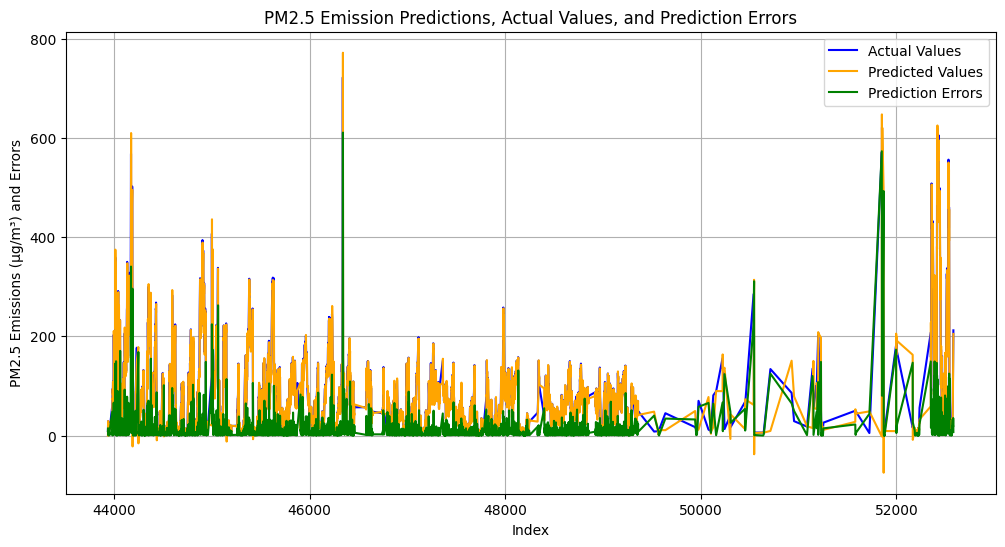

In [12]:
# Predictions on the validation set
predictions = []
validation_array = validation_set['PM_US Post'].values

for x in range(len(validation_array)):
    s = 0
    for y in range(3):  # Use the 3 most recent lags (t-1, t-2, t-3)
        if x - y - 1 >= 0:  # Check if the index is ok
            s += ar_model.params[f'PM_US Post.L{y + 1}'] * validation_array[x - y - 1]
    predictions.append(s)

# Calculate the prediction errors
errors = abs(validation_array - predictions)

# Calculate MAE
mae = mean_absolute_error(validation_array, predictions)
print("Mean absolute error = " + str(mae))
mape = np.mean(np.abs((validation_array - predictions)/len(validation_array)))*100
print("Mean absolute percentage error = " + str(mape) + "%   ==> which is less than 5% so it is acceptable.")

# Plot our actual vs. predicted values and prediction errors on the same graph
plt.figure(figsize=(12, 6))
# Plot our actual values
plt.plot(validation_set.index, validation_array, label="Actual Values", color='blue')
# Plot our predicted values
plt.plot(validation_set.index, predictions, label="Predicted Values", color='orange')
# Plot our prediction errors
plt.plot(validation_set.index, errors, label="Prediction Errors", color='green')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('PM2.5 Emissions (µg/m³) and Errors')
plt.title('PM2.5 Emission Predictions, Actual Values, and Prediction Errors')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Firstly, we observed that our autoregressive (AR) model with 3 lags tends to **converge toward an average value** in its predictions when using recursive predictions, which can reduce forecast accuracy (producing a nearly straight line). This convergence results from the model’s tendency to "average" past values, leading to forecasts that fail to capture the actual dynamics of PM2.5 fluctuations.

To avoid this undesirable convergence, we opted for a **manual implementation of predictions**. Instead of generating predictions recursively with the `AutoReg` and `AutoReg.predict` functions, we calculated each prediction independently using the **coefficients obtained during model training**. Specifically, for each prediction point, we multiplied the three most recent values of the time series ($t-1$, $t-2$, and $t-3$) by their respective coefficients and then summed these weighted values to obtain the final prediction. This approach allows us to **preserve realistic variability** in the predictions, better capturing the fluctuations in the actual values without smoothing them toward an average.

In the plot, we observe our three key elements: **actual values**, **predicted values**, and **prediction errors**.

### Actual Values

Our **actual values** represent the observed PM2.5 emissions levels in Beijing for the validation period. These values are shown in **blue** on the plot and serve as our benchmark for evaluating the accuracy of the predicted values. The actual values exhibit high variability, with several spikes and drops, reflecting the dynamic nature of PM2.5 emissions, which can be influenced by factors such as weather conditions, traffic, and industrial activity.

### Predicted Values

Our **predicted values**, shown in **orange**, are generated using our autoregressive (AR) model with 3 lags and no constant term (`trend='n'`). These predictions are calculated independently for each point (without recursion) by applying the coefficients obtained from model training to the three most recent values in the time series. This approach allows the predictions to capture the short-term trends in the data, preventing the model from converging towards a constant average value, which was a limitation in our previous recursive approach. The predicted values closely follow the actual values, especially in periods of moderate fluctuation. However, in certain areas, particularly during brutal increases or decreases, the predictions may exceed the actual values, suggesting a sensitivity to recent fluctuations that could probably be refined by incorporating additional factors.

### Prediction Errors

Our **prediction errors**, shown in **green**, represent the absolute difference between the actual and predicted values at each point in the validation period. The errors generally stay relatively low, indicating that the predictions are closely aligned with the actual values for most of the period. However, we observe some **spikes in error** corresponding to moments where the predicted values exceed the actual emissions. These spikes highlight instances where the model might be overreacting to recent trends (possibly due to sudden changes in PM2.5 levels that the model cannot fully capture with just three lags ?). Despite that, the overall error distribution is more consistent than with our before recursive approach. Maybe the model's accuracy could potentially be enhanced by increasing the number of lags or integrating additional **explanatory variables** (such as weather data).

Overall, the manual prediction method has proven effective in capturing the variability of PM2.5 emissions. While some overshooting occurs, particularly during sharp fluctuations, the consistency of the errors demonstrates that this approach better matches the underlying patterns in the data. The **mean absolute error (MAE)** of **12.17 µg/m³** and the **mean absolute percentage error (MAPE)** of **0.26%** further validate the model's accuracy, as the MAPE is well below the commonly acceptable threshold of 5%. This low percentage error indicates that our model performs reliably in predicting PM2.5 levels. We believe that adding additional lags or incorporating explanatory variables could further refine these predictions!

## 4. Hypothesis tests

------------------------------------------------------------------------------------------------------
4.1. You will compare the average PM2.5 emissions measured at the US embassy in Beijing (PM_US Post_y), during winter with emissions reported by Chinese authorities in Nongzhanguan (PM_Nongzhanguan), a district of Beijing close to the US embassy.

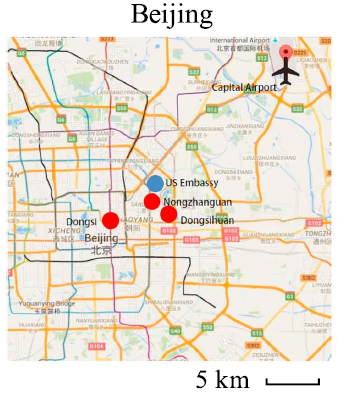


a) Reload the data from 'BeijingPM.csv' file. Keep data from the 1/1/2012 and 31/12/2015 in winter time(season 4). Take care to remove missing data (NA) and keep only days for which PM2.5 emissions are available **both** in Nongzhanguan (PM_Nongzhanguan) and Beijing (PM_US Post), to keep the same number of observations.

------------------------------------------------------------------------------------------------------

In [13]:
# Reload the BeijingPM.csv dataset and remove missing data
beijing_pm_reloaded = pd.read_csv('BeijingPM.csv', na_values=['NA'])
# Keep data from the 1/1/2012 and 31/12/2015
beijing_pm_reloaded = beijing_pm_reloaded[(beijing_pm_reloaded['year'] >= 2012) & (beijing_pm_reloaded['year'] <= 2015)]
# Keep only winter time (season 4)
winter_data_reloaded = beijing_pm_reloaded[beijing_pm_reloaded['season'] == 4]
# Remove missing data in PM_US Post OR PM_Nongzhanguan (we want both!)
winter_data_reloaded_cleaned = winter_data_reloaded.dropna(subset=['PM_US Post', 'PM_Nongzhanguan'])

# Just for cleanliness
winter_data_reloaded_cleaned.reset_index(drop=True, inplace=True)

# For debugging
#print(winter_data_reloaded_cleaned)

b) Perfom a  the Stutent's T test to check if the average hourly PM2.5 emissions are the same in Nongzhanguan and at the US embassy. The null hypothesis is

$H_0$: $\mu_{US} = \mu_{Nongzhanguan}$.

Use a confidence level of 5%. Take care to comment your conclusions. Are all assumptions required to perform this test sastisfied?


In [14]:
print("First, why using Stdent's Test ? We are comparing the means of two independent samples (PM2.5 emissions at the US embassy and at Nongzhanguan).\nThe Student's test allows us to determine if there is a statistically significant difference between the two means.\nSo, we will use the paired Student's t-test")

# Extract PM2.5 measurements
us_pm25 = winter_data_reloaded_cleaned['PM_US Post']
nong_pm25 = winter_data_reloaded_cleaned['PM_Nongzhanguan']

# Calculate the differences (delta in our stats form)
differences = us_pm25 - nong_pm25

# Alpha and confidence level
alpha = 0.05
confidence_level = 1 - alpha

# Perform the Student test
t_statistic, p_value = st.ttest_ind(us_pm25, nong_pm25)
# t_statistic, p_value = st.ttest_rel(us_pm25, nong_pm25)

# Output our results
#print(f"T-statistic: {t_statistic}")
#print(f"P-value: {p_value}")
df_test_results = pd.DataFrame({
    "T-statistic": [t_statistic],
    "P-value": [p_value],
    "Confidence Level": [confidence_level]
})
display(df_test_results)

if p_value < alpha:
    print("We reject the null hypothesis.")
    print("=> There is a statistically significant difference between the mean PM2.5 emissions at the US embassy and Nongzhanguan.")
else:
    print("We fail to reject the null hypothesis.")
    print("=> There is no statistically significant difference between the mean PM2.5 emissions at the US embassy and Nongzhanguan.")


First, why using Stdent's Test ? We are comparing the means of two independent samples (PM2.5 emissions at the US embassy and at Nongzhanguan).
The Student's test allows us to determine if there is a statistically significant difference between the two means.
So, we will use the paired Student's t-test


,T-statistic,P-value,Confidence Level
0,3.661708,0.000252,0.95


We reject the null hypothesis.
=> There is a statistically significant difference between the mean PM2.5 emissions at the US embassy and Nongzhanguan.


Initially, we considered using the **paired Student's t-test (`ttest_rel`)** since the PM2.5 measurements are taken at the same times and locations close to each other, suggesting that the observations could be paired.

However, because the data are collected by two different entities (the US embassy and Chinese authorities) we decided to treat the samples as **independent**. This is due to potential differences in measurement methods, data collection protocols or the confidence shown by the measurements which may introduce variability that violates the assumption of paired observations.

Therefore, we will use the **independent samples t-test (`ttest_ind`)**.

Since the p-value is **significantly less** than our significance level of **0.05**, __**we reject the null hypothesis**__. 
=> There is a statistically significant difference between the mean PM2.5 emissions at the US embassy and Nongzhanguan.

**To contextualize our result, we refer to the following table:**

| Decision/Reality | H0 is true   | H1 is true   |
|------------------|--------------|--------------|
| Accept H0        | Correct      | Type 2 error |
| Rejet H0         | Type 1 error | Correct      |

By rejecting $H_0$, we risk committing a Type I Error if $H_0$ is actually true. However, given the extremely low p-value, the probability of a Type I Error is minimal.

Our test is predicated on the fulfillment of four assumptions : 
1. **Independence**: The PM2.5 measurements at the US embassy and Nongzhanguan are collected independently by two different entities, which supports the assumption of independence between samples. **However**, since the data are collected at locations that are relatively close to each other and at the same time, there may be correlation between samples (simultaneous measurements within the same geographic area may be correlated). This violates the assumption of independence between samples.
2. **Measurement Scale**: The data are measured on a ratio scale, allowing for meaningful comparisons. PM2.5 concentrations are measured in micrograms per cubic meter (µg/m³), which is a ratio scale.
3. **Random Sampling**: The data points represent typical hourly PM2.5 emissions during winter, and the data collection methods are unbiased and systematic. While the data collection may not be purely random, measurements are taken systematically over time, which is acceptable for time series data.
4. **Normal distribution**: Assuming the sample size is large, the **Central Limit Theorem (TCL)** suggests that the sampling distribution of the mean will be approximately normal

**So, all assumptions required to perform the independent samples t-test are not fully satisfied.**

Using the paired t-test, we also reject the null hypothesis.

c) Explain the Wilcoxon's test. What is the main advantage of this test compared to the Student's T test. Why is this useful in our project? 

The main advantage of the **Wilcoxon's test over the Student's t-test** is that it is **non-parametric**. It does not rely on the assumption that the data follows a normal distribution. The primary advantage of a non-parametric test like the Wilcoxon's test is its robustness to violations of the normality assumption. In cases where the data do not follow a normal distribution, the Wilcoxon's test can still provide reliable results, whereas the Student's t-test may not be appropriate under such conditions.

So, the **main advantage** of the Wilcoxon's test is its ability to handle non-normally distributed data, making it a valuable tool when dealing with real-world data that doesn't meet the strict assumptions of the Student's t-test.

In our project, applying the Wilcoxon's test allows us to **validate our findings** regarding PM2.5 emissions and ensures that our conclusions are **reliable** despite any potential deviations from normality or the presence of outliers.

d) Apply the Wilcoxon's test to distributions of the hourly PM2.5 emissions in Nongzhanguan and at the US embassy. What can you conclude ?

In [15]:
from scipy import stats

# Extract PM2.5 measurements
us_pm25 = winter_data_reloaded_cleaned['PM_US Post']
nong_pm25 = winter_data_reloaded_cleaned['PM_Nongzhanguan']

# Perform the Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(us_pm25, nong_pm25)

# Output our results
#print("Wilcoxon Test Statistic = ", statistic)
#print("p-value = ", p_value)
df_wilcoxon_results = pd.DataFrame({
    "Wilcoxon Statistic": [statistic],
    "P-value": [p_value]
})
display(df_wilcoxon_results)

,Wilcoxon Statistic,P-value
0,4283393.0,2.787663e-186


*Hypothesis :*

- H0 : The distributions of PM2.5 emissions at both locations are the same
- Ha : The distributions of PM2.5 emissions at both locations are different

Since the p-value = 2.787663e-186 > alpha = 0.05, **we reject H0.**

**=> We can conclude that there is strong statistical evidence that the distributions of hourly PM2.5 emissions at the US embassy and Nongzhanguan are significantly different during the winter months from 2012 to 2015.**
